In [1]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image 
import skimage
from skimage import io
from skimage import color
from skimage.color import rgb2gray
from skimage import data
from skimage import filters
from skimage import feature
from skimage.transform import resize
from skimage.io import imsave, imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#---------------------------------------------------------------------------------------------#

OriginalImages = []
DownsampledImages = []
DownsampledImagesTest = []
UpsampledImages = []
labels=[]
lables_test=[]
OriginalImagesTest = []
d=[]
f=[]
y=0

for dirname, _, filenames in os.walk('/kaggle/input/cfpw-dataset/cfp-dataset/Data/Images'):
    y+=1
    i=0
    for filename in filenames:
        i+=1
        d.append(dirname)
        x=dirname
        f.append(filename)
        if(x[-7:]=="frontal"):
            if(i<=3):
                image = os.path.join(dirname, filename)
                OriginalImages.append( os.path.join(dirname, filename))
                labels.append(y)
            elif(i==4):
                image = os.path.join(dirname, filename)
                OriginalImagesTest.append( os.path.join(dirname, filename))
                lables_test.append(y)
                break
        else:
            break
        
print('Total images present in Training Set : ', len(OriginalImages))
print('Total images present in Testing Set : ', len(OriginalImagesTest))



Total images present in Training Set :  1500
Total images present in Testing Set :  500


In [2]:
def displayImage(imagePath):
    image = mpimg.imread(imagePath)
    plt.imshow(image)
    print('Image path', imagePath)
    print('Image size -', image.shape)
    plt.show()

In [3]:
image_gray=[]
imagetest_gray=[]
image=[]
imagetest=[]

In [4]:
def grayscale_image(imageIndex):
    imagePath = OriginalImages[imageIndex]
    image = cv2.imread( imagePath)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   
    image_gray.append(grayscale.astype('uint8'))

    

In [5]:
def grayscale_image_test(imageIndex):
    imagePath = OriginalImagesTest[imageIndex]
    image = cv2.imread( imagePath)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imagetest_gray.append(grayscale.astype('uint8'))

In [6]:
def reshape_image(imageIndex):
    
    image1 = image_gray[imageIndex] 
    resized = cv2.resize(image1, (256, 256))
    image.append(resized.astype('uint8'))

In [7]:
def reshape_image_test(imageIndex):
    
    image1 = imagetest_gray[imageIndex]
    resized = cv2.resize(image1, (256, 256))
    imagetest.append(resized.astype('uint8'))

In [8]:
for i in range(len(OriginalImages)):
    grayscale_image(i)
for i in range(len(OriginalImagesTest)):
    grayscale_image_test(i)

In [9]:
for i in range(len(OriginalImages)):
    reshape_image(i)
for i in range(len(OriginalImagesTest)):
    reshape_image_test(i)

In [10]:
def Downsample_train(imageIndex):
    
    imagePath = image[imageIndex]
    image1 = imagePath
    m, n = image1.shape
    f = 4
    image2 = np.zeros([m//f + 1, n//f + 1])
    
    for i in range(0,m):
        for j in range(0,n):
            image2[i//f, j//f] = image1[i, j]
    return image2



In [11]:
def Downsample_test(imageIndex):

    image1 = imagetest[imageIndex]
    m, n = image1.shape

    f = 4
    image2 = np.zeros([m//f + 1, n//f + 1])
    
    for i in range(0,m):
        for j in range(0,n):
            image2[i//f, j//f] = image1[i, j]
    
    return image2


In [12]:
for i in range(len(image)):
    DownsampledImages.append(Downsample_train(i))

for i in range(len(imagetest)):  
    DownsampledImagesTest.append(Downsample_test(i))

In [13]:
x_train_val = DownsampledImages
x_train_label = labels
x_test_val= DownsampledImagesTest
x_test_val=x_test_val
x_test_label= lables_test

print('Total images in DownSampled Training set ', len(x_train_val))
print('Total images in DownSampled Testing set', len(x_test_val))

Total images in DownSampled Training set  1500
Total images in DownSampled Testing set 500


In [14]:
DownsampledImages[0].shape
DownsampledImagesTest[0].shape

(65, 65)

Text(0.5, 0.98, 'DownSampled Images')

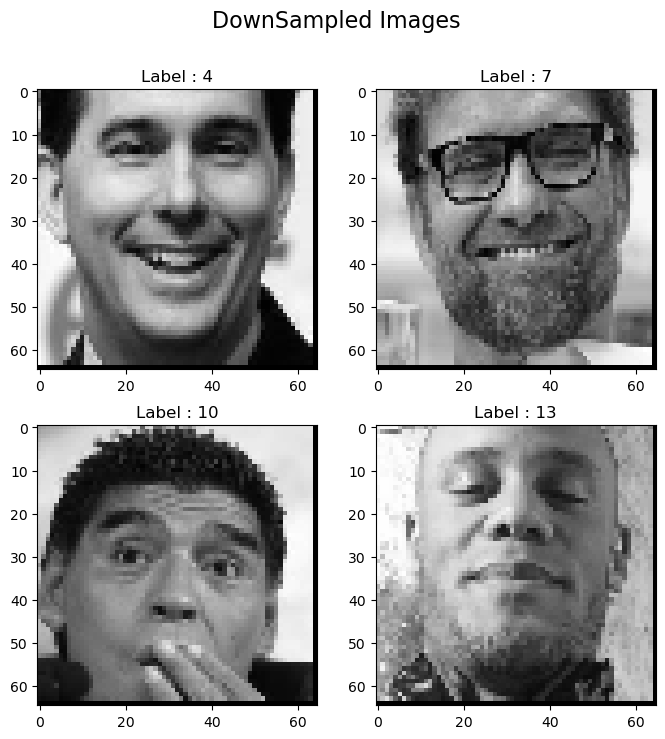

In [15]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))


axes[0, 0].imshow(DownsampledImages[0], cmap='gray')
axes[0, 0].set_title("Label : 4" )
axes[0, 1].imshow(DownsampledImages[3], cmap='gray')
axes[0, 1].set_title("Label : 7")
axes[1, 0].imshow(DownsampledImages[6], cmap='gray')
axes[1, 0].set_title("Label : 10")
axes[1, 1].imshow(DownsampledImages[9], cmap='gray')
axes[1, 1].set_title("Label : 13")

fig.suptitle("DownSampled Images", fontsize=16)

# Building Model

In [16]:
epochs = 150
batch_size = 16
margin = 1  

In [17]:
x_train, x_val = x_train_val[:750], x_train_val[750:]
y_train, y_val = x_train_label[:750], x_train_label[750:]
del x_train_val, x_train_label

#print(y_train)
print('No of Images in training set : ',len(x_train))
print('No of Images in validation set : ',len(x_val))

No of Images in training set :  750
No of Images in validation set :  750


In [18]:
def make_pairs(x, y):
  
    num_classes = max(y) + 1
    from collections import defaultdict
    digit_indices = defaultdict(list)
    for i, label in enumerate(y):
         digit_indices[label].append(i)
   
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        pairs += [[x1, x2]]
        labels += [0]

        label2 = random.randint(0, num_classes - 1)
        while label2 == label1 or label2 not in digit_indices :
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs, dtype=object), np.array(labels).astype("float32")



       


In [19]:
#making test pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# making validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# making test pairs
pairs_test, labels_test = make_pairs(x_test_val, x_test_label)

In [20]:
pairs_train.shape

(1500, 2, 65, 65)

In [21]:
pairs_val.shape

(1500, 2, 65, 65)

In [22]:
pairs_test.shape

(1000, 2, 65, 65)

In [23]:
x_train_1 = pairs_train[:, 0] 
x_train_2 = pairs_train[:, 1]

In [24]:
x_val_1 = pairs_val[:, 0]  
x_val_2 = pairs_val[:, 1]

In [25]:
x_test_1 = pairs_test[:, 0]  
x_test_2 = pairs_test[:, 1]

#  **Visualizing**

In [26]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
   
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0].astype(np.float32), pairs[i][1].astype(np.float32)], axis=1), cmap="gray")
        ax.set_axis_off()
        
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

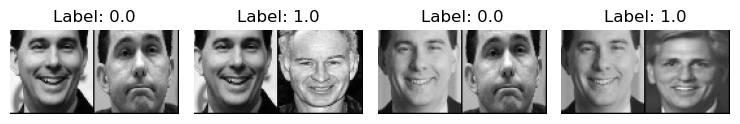

In [27]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

In [28]:

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((65, 65, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((65, 65,1))
input_2 = layers.Input((65, 65,1))


tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [29]:
def loss(margin=1):
    
    def contrastive_loss(y_true, y_pred):
        

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [30]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65, 65, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 65, 65, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           39590       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [31]:
history = siamese.fit(
    [np.array(x_train_1).astype(np.float32), np.array(x_train_2).astype(np.float32)],
    np.array(labels_train).astype(np.float32),
    validation_data=([np.array(x_val_1).astype(np.float32), np.array(x_val_2).astype(np.float32)], np.array(labels_val).astype(np.float32)),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/150
94/94 [==============================] - 8s 66ms/step - loss: 0.1803 - accuracy: 0.7380 - val_loss: 0.1693 - val_accuracy: 0.7167
Epoch 2/150
94/94 [==============================] - 5s 58ms/step - loss: 0.1756 - accuracy: 0.7413 - val_loss: 0.1581 - val_accuracy: 0.7520
Epoch 3/150
94/94 [==============================] - 5s 58ms/step - loss: 0.1647 - accuracy: 0.7560 - val_loss: 0.1505 - val_accuracy: 0.7673
Epoch 4/150
94/94 [==============================] - 5s 58ms/step - loss: 0.1654 - accuracy: 0.7600 - val_loss: 0.1475 - val_accuracy: 0.7707
Epoch 5/150
94/94 [==============================] - 6s 59ms/step - loss: 0.1563 - accuracy: 0.7773 - val_loss: 0.1538 - val_accuracy: 0.7707
Epoch 6/150
94/94 [==============================] - 6s 63ms/step - loss: 0.1569 - accuracy: 0.7787 - val_loss: 0.1401 - val_accuracy: 0.7860
Epoch 7/150
94/94 [==============================] - 5s 59ms/step - loss: 0.1537 - accuracy: 0.7807 - val_loss: 0.1417 - val_accuracy: 0.7973
Epoch 

In [32]:
# serialize the model to disk
print("[INFO] saving siamese model...")
siamese.save("C:/Users/Khushi/Documents/new_dataset")


[INFO] saving siamese model...


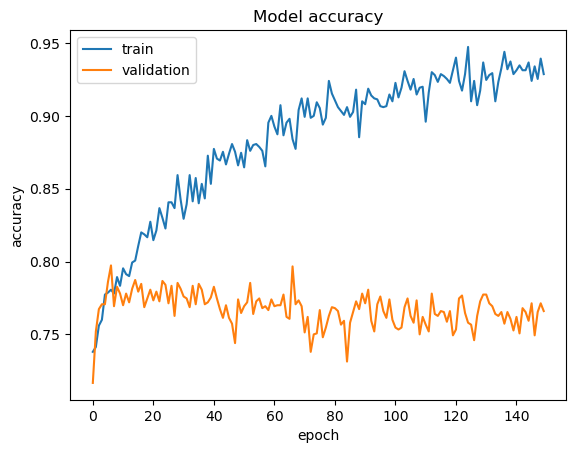

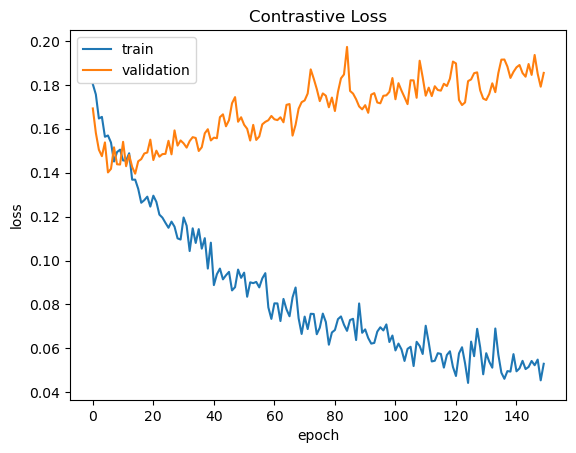

In [33]:
def plt_metric(history, metric, title, has_valid=True):
   
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


plt_metric(history=history.history, metric="accuracy", title="Model accuracy")
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [34]:
results = siamese.evaluate([x_test_1.astype(np.float32), x_test_2.astype(np.float32)], labels_test)
print("test loss, test acc:", results)

32/32 [==============================] - 1s 23ms/step - loss: 0.0784 - accuracy: 0.8920
test loss, test acc: [0.07842837274074554, 0.8920000195503235]


32/32 [==============================] - 1s 23ms/step


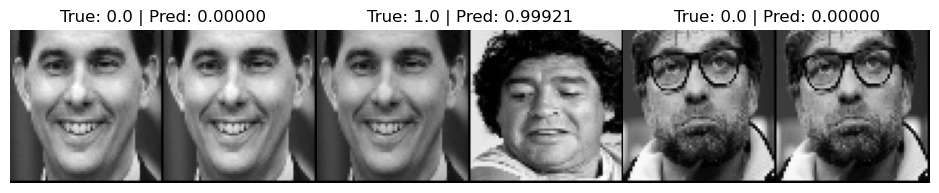

In [35]:
predictions = siamese.predict([x_test_1.astype(np.float32), x_test_2.astype(np.float32)])
visualize(pairs_test, labels_test, to_show=5, predictions=predictions, test=True)

# Testing


### Test Case 1

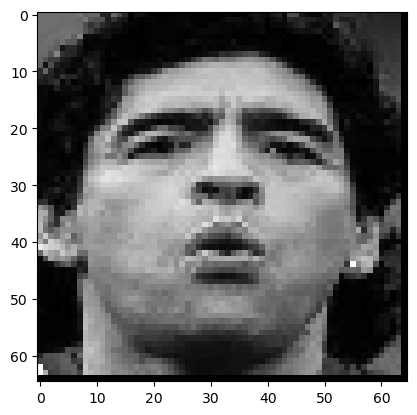

In [36]:
image_to_show = DownsampledImages[8]
plt.imshow(image_to_show, cmap=plt.cm.gray)
plt.show()



In [37]:
def gaussian_kernel(size, sigma= 5):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x*2 + y*2) / (2.0*sigma*2))) * normal
    return g
    

In [38]:
def convolution(image, kernel, average=False):
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    return output

In [39]:
import math
def gaussian_blur(image, kernel_size):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size))
    return convolution(image, kernel, average=True)

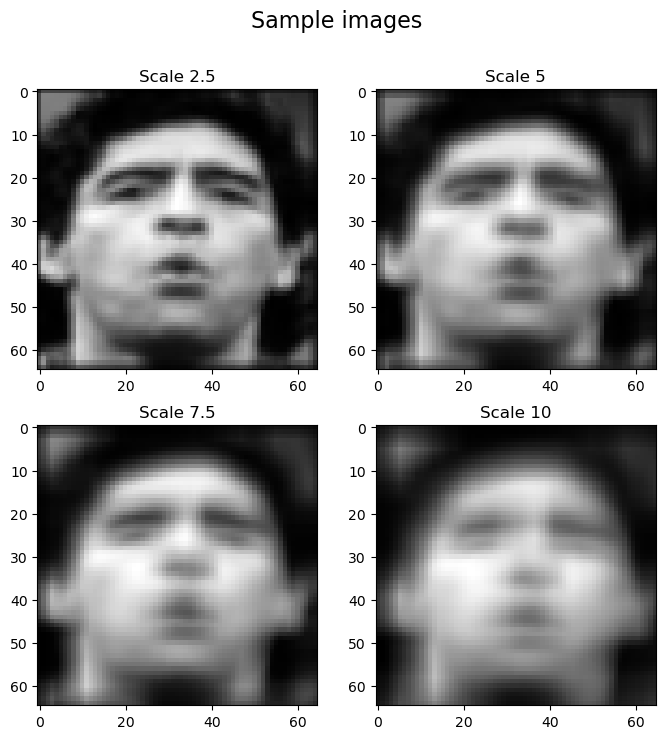

In [40]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

axes[0, 0].imshow(gaussian_blur( image_to_show, 2.5), cmap='gray')
axes[0, 0].set_title("Scale 2.5")

# Plot images in the second subplot
axes[0, 1].imshow(gaussian_blur( image_to_show, 5), cmap='gray')
axes[0, 1].set_title("Scale 5")

# Plot images in the third subplot
axes[1, 0].imshow(gaussian_blur( image_to_show, 7.5), cmap='gray')
axes[1, 0].set_title("Scale 7.5")

# Plot images in the fourth subplot
axes[1, 1].imshow(gaussian_blur( image_to_show, 10), cmap='gray')
axes[1, 1].set_title("Scale 10")

# Add a main title to the figure
fig.suptitle("Sample images", fontsize=16)

# Show the plot
plt.show()

In [41]:
x_test_10=gaussian_blur(image_to_show,5)
x_test_11=gaussian_blur(image_to_show,2.5)

x_test_11.shape



(65, 65)

In [42]:

test_image = x_test_10
test_image2 = x_test_11


x_test_1 = np.zeros((1, 65, 65))
x_test_2 = np.zeros((1, 65, 65))

x_test_1[0, :, :] = test_image
x_test_2[0, :, :] = test_image2


feature_vector = siamese.predict([x_test_1, x_test_2])

1/1 [==============================] - 0s 28ms/step


In [43]:

pair_test=[]
pair_test.append((x_test_10,x_test_11))

labels_tt=[]
labels_tt.append(0)





In [44]:
def visualize2(pairs, labels, to_show=1, num_col=1, predictions=None, test=False):
   

    num_row = to_show // num_col if to_show // num_col != 0 else 1

   
    to_show = num_row * num_col
    print(to_show)
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        if num_row == 1:
            ax = axes
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            if predictions.shape[0] == 1:
                ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], np.squeeze(predictions)))
            else:
                ax.set_title("True: {} | Pred: {:.5f}".format(labels_tt[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels_tt[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()




In [45]:

pair_test_array = np.array(pair_test)

print(pair_test_array.shape)



(1, 2, 65, 65)


1


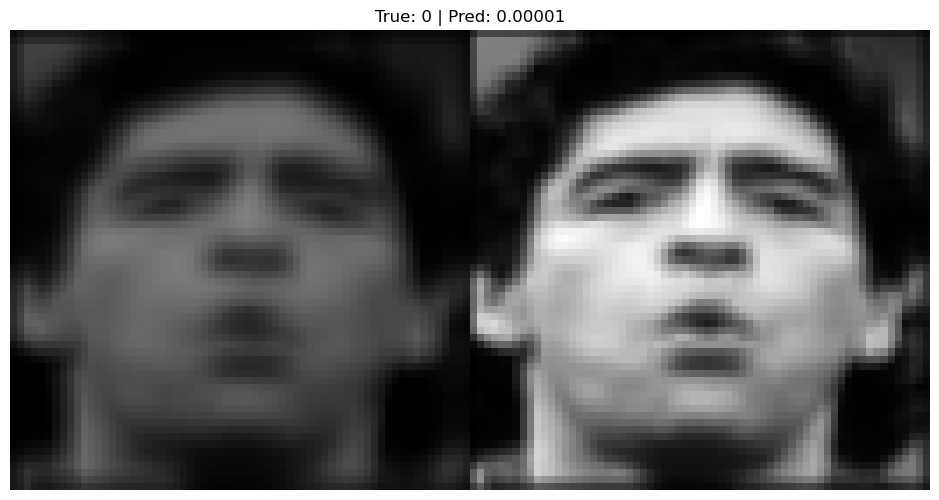

In [46]:
visualize2(pair_test_array, labels_tt, to_show=1, num_col=1, predictions=feature_vector, test=True)

### Test Case 2

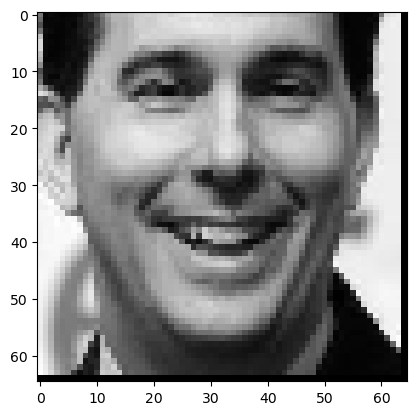

In [47]:
image_to_show = DownsampledImages[0]
plt.imshow(image_to_show, cmap=plt.cm.gray)
plt.show()

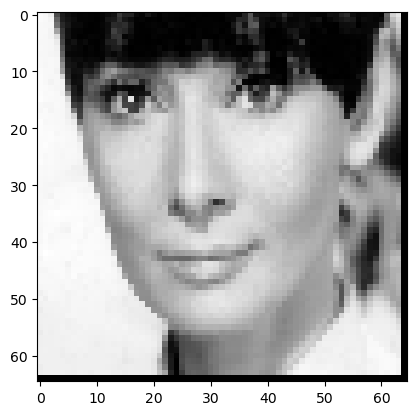

In [48]:
image_to_show1 = DownsampledImagesTest[29]
plt.imshow(image_to_show1, cmap=plt.cm.gray)
plt.show()

In [49]:

x_test_val3=[]
x_test_label3=[]

x_test_val3.append(image_to_show)
x_test_val3.append(image_to_show1)

x_test_label3.append(labels[0])
x_test_label3.append(labels_test[29])

In [50]:
pairs2_test, labels2_test = make_pairs(x_test_val3, x_test_label3)

In [51]:
x_test_12 = pairs2_test[:, 0]  
x_test_22 = pairs2_test[:, 1]


In [52]:
results = siamese.evaluate([x_test_12.astype(np.float32), x_test_22.astype(np.float32)], labels2_test)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 33ms/step - loss: 8.9319e-06 - accuracy: 1.0000
test loss, test acc: [8.931928277888801e-06, 1.0]


1/1 [==============================] - 0s 27ms/step


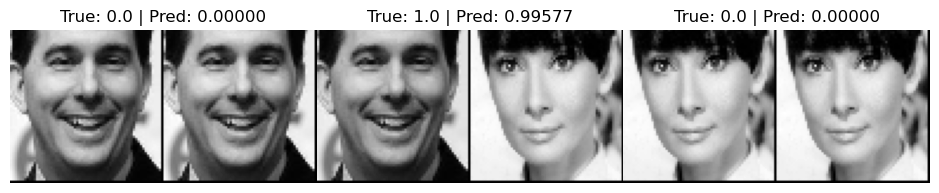

In [53]:
predictions = siamese.predict([x_test_12.astype(np.float32), x_test_22.astype(np.float32)])
visualize(pairs2_test, labels2_test, to_show=3, predictions=predictions, test=True)

In [54]:
# def visualize3(pairs, labels, to_show, num_col, predictions=None, test=False):
#     """
#     Visualize pairs of images with their labels and predictions (optional).
#     """
#     num_row = to_show // num_col if to_show // num_col != 0 else 1

   
#     to_show = num_row * num_col
#     print(to_show)
    
#     fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
#     for i in range(to_show):
#         if num_row == 1:
#             ax = axes
#         else:
#             ax = axes[i // num_col, i % num_col]

#         ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
#         ax.set_axis_off()
#         if test:
#             if predictions.shape[0] == 1:
#                 ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], np.squeeze(predictions)))
#             else:
#                 ax.set_title("True: {} | Pred: {:.5f}".format(labels_tt[i], predictions[i][0]))
#         else:
#             ax.set_title("Label: {}".format(labels_tt[i]))
#     if test:
#         plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
#     else:
#         plt.tight_layout(rect=(0, 0, 1.5, 1.5))
#     plt.show()

### Test Case 3

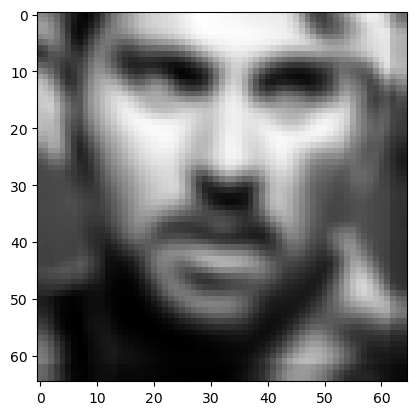

In [55]:
image_to_show = DownsampledImages[29]
image_to_show=cv2.GaussianBlur(image_to_show, (5,5), 3)
plt.imshow(image_to_show, cmap=plt.cm.gray)
plt.show()

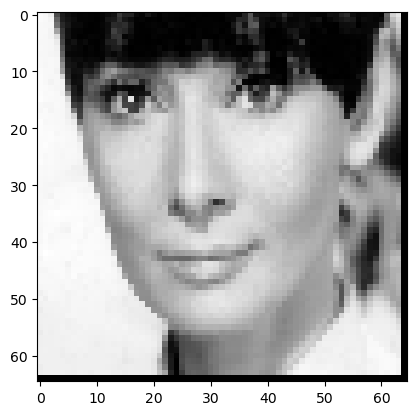

In [56]:
image_to_show1 = DownsampledImagesTest[29]
plt.imshow(image_to_show1, cmap=plt.cm.gray)
plt.show()

In [57]:
x_test_val4=[]
x_test_label4=[]

x_test_val4.append(image_to_show)
x_test_val4.append(image_to_show1)

x_test_label4.append(labels[29])
x_test_label4.append(labels_test[29])



In [58]:
pairs3_test, labels3_test = make_pairs(x_test_val4, x_test_label4)

In [59]:
x_test_13 = pairs3_test[:, 0]  
x_test_23 = pairs3_test[:, 1]


In [60]:
results = siamese.evaluate([x_test_13.astype(np.float32), x_test_23.astype(np.float32)], labels3_test)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 31ms/step - loss: 3.7570e-07 - accuracy: 1.0000
test loss, test acc: [3.756983630864852e-07, 1.0]


1/1 [==============================] - 0s 27ms/step


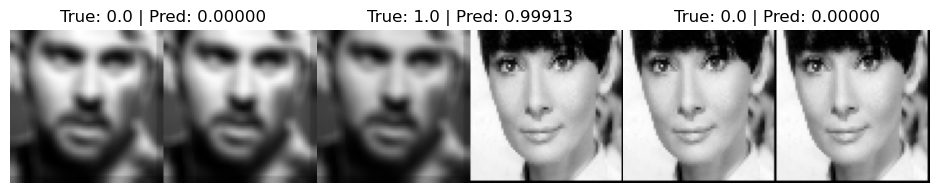

In [61]:
predictions = siamese.predict([x_test_13.astype(np.float32), x_test_23.astype(np.float32)])
visualize(pairs3_test, labels3_test, to_show=3, predictions=predictions, test=True)

### Test Case 4

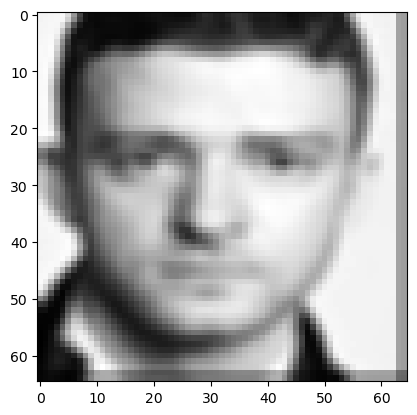

In [62]:
image_to_show = DownsampledImages[123]
image_to_show= cv2.GaussianBlur(image_to_show, (3,3), 3)
plt.imshow(image_to_show, cmap=plt.cm.gray)
plt.show()

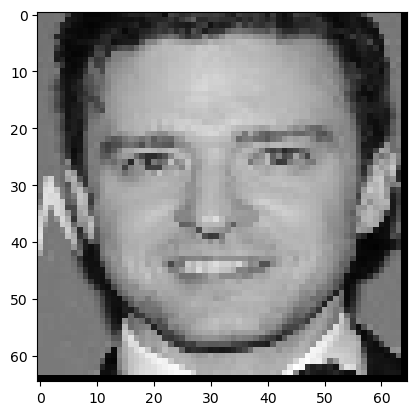

In [63]:
image_to_show1 = DownsampledImagesTest[41]
plt.imshow(image_to_show1, cmap=plt.cm.gray)
plt.show()

1/1 [==============================] - 0s 32ms/step - loss: 0.5000 - accuracy: 0.5000
test loss, test acc: [0.49999773502349854, 0.5]
1/1 [==============================] - 0s 26ms/step


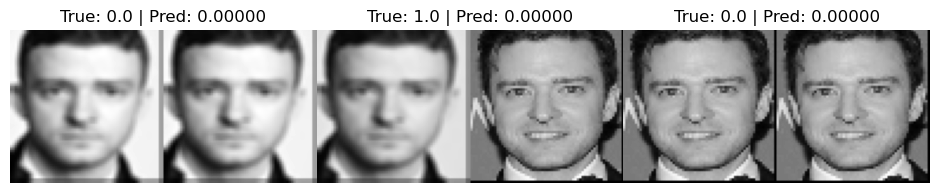

In [64]:
x_test_val5=[]
x_test_label5=[]

x_test_val5.append(image_to_show)
x_test_val5.append(image_to_show1)

x_test_label5.append(labels[123])
x_test_label5.append(labels_test[41])

pairs4_test, labels4_test = make_pairs(x_test_val5, x_test_label5)

x_test_14 = pairs4_test[:, 0]  
x_test_24 = pairs4_test[:, 1]

results = siamese.evaluate([x_test_14.astype(np.float32), x_test_24.astype(np.float32)], labels4_test)
print("test loss, test acc:", results)


predictions = siamese.predict([x_test_14.astype(np.float32), x_test_24.astype(np.float32)])
visualize(pairs4_test, labels4_test, to_show=3, predictions=predictions, test=True)


### Test Case 5

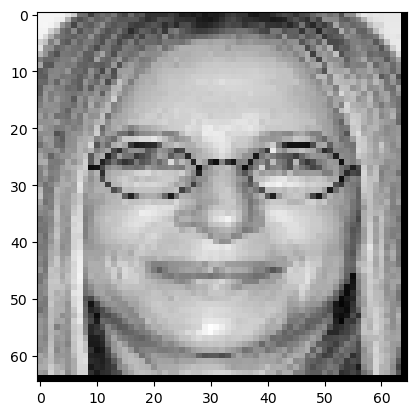

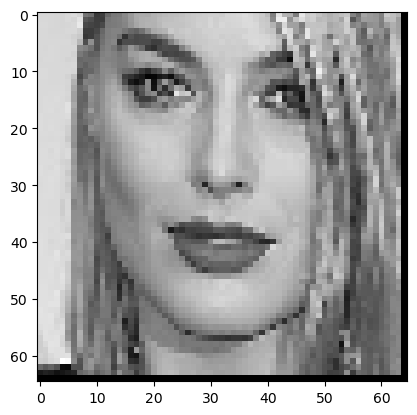

1/1 [==============================] - 0s 33ms/step - loss: 7.9617e-06 - accuracy: 1.0000
test loss, test acc: [7.96169388195267e-06, 1.0]
1/1 [==============================] - 0s 27ms/step


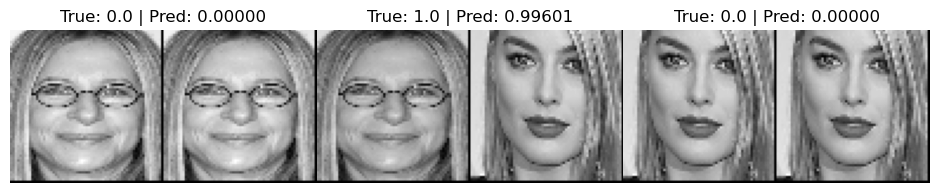

In [65]:
image_to_show = DownsampledImages[15]
# image_to_show=cv2.GaussianBlur(image_to_show, (2.5,2.5), 3)
plt.imshow(image_to_show, cmap=plt.cm.gray)
plt.show()

image_to_show1 = DownsampledImagesTest[6]
plt.imshow(image_to_show1, cmap=plt.cm.gray)
plt.show()

x_test_val6=[]
x_test_label6=[]

x_test_val6.append(image_to_show)
x_test_val6.append(image_to_show1)

x_test_label6.append(labels[15])
x_test_label6.append(labels_test[6])

pairs5_test, labels5_test = make_pairs(x_test_val6, x_test_label6)

x_test_15 = pairs5_test[:, 0]  
x_test_25 = pairs5_test[:, 1]

results = siamese.evaluate([x_test_15.astype(np.float32), x_test_25.astype(np.float32)], labels5_test)
print("test loss, test acc:", results)


predictions = siamese.predict([x_test_15.astype(np.float32), x_test_25.astype(np.float32)])
visualize(pairs5_test, labels5_test, to_show=3, predictions=predictions, test=True)


### Test Case 6

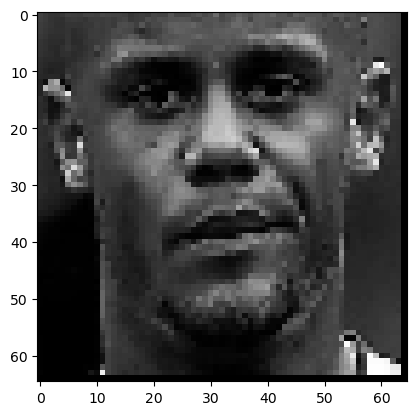

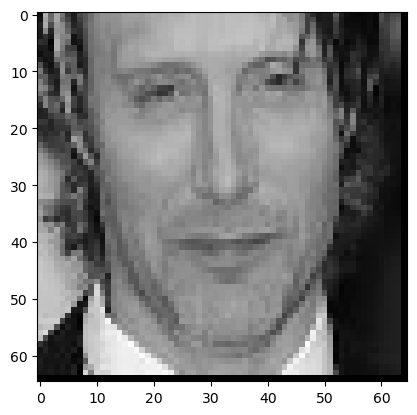

1/1 [==============================] - 0s 32ms/step - loss: 7.9617e-06 - accuracy: 1.0000
test loss, test acc: [7.96169388195267e-06, 1.0]
1/1 [==============================] - 0s 27ms/step


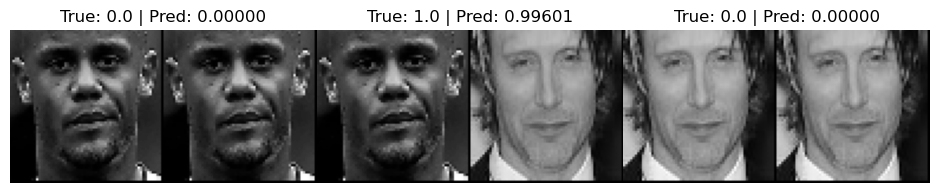

In [66]:

image_to_show = DownsampledImages[11]
# image_to_show=cv2.GaussianBlur(image_to_show, (2.5,2.5), 3)
plt.imshow(image_to_show, cmap=plt.cm.gray)
plt.show()

image_to_show1 = DownsampledImagesTest[46]
plt.imshow(image_to_show1, cmap=plt.cm.gray)
plt.show()



x_test_val7=[]
x_test_label7=[]

x_test_val7.append(image_to_show)
x_test_val7.append(image_to_show1)

x_test_label7.append(labels[29])
x_test_label7.append(labels_test[9])

pairs6_test, labels6_test = make_pairs(x_test_val7, x_test_label7)

x_test_16 = pairs5_test[:, 0]  
x_test_26 = pairs5_test[:, 1]

results = siamese.evaluate([x_test_16.astype(np.float32), x_test_26.astype(np.float32)], labels6_test)
print("test loss, test acc:", results)


predictions = siamese.predict([x_test_16.astype(np.float32), x_test_26.astype(np.float32)])
visualize(pairs6_test, labels6_test, to_show=3, predictions=predictions, test=True)


### Test Case 7

In [67]:
test_image = DownsampledImages[123]
test_image2 = DownsampledImagesTest[41]


x_test_1 = np.zeros((1, 65, 65))
x_test_2 = np.zeros((1, 65, 65))

x_test_1[0, :, :] = test_image
x_test_2[0, :, :] = test_image2


feature_vector = siamese.predict([x_test_1, x_test_2])
feature_vector 

1/1 [==============================] - 0s 25ms/step


array([[0.0005093]], dtype=float32)

In [68]:
pair_test=[]
pair_test.append((DownsampledImages[123],DownsampledImagesTest[41]))

labels_tt=[]
labels_tt.append(0)

In [69]:
def visualize2(pairs, labels, to_show=1, num_col=1, predictions=None, test=False):
   

    num_row = to_show // num_col if to_show // num_col != 0 else 1

   
    to_show = num_row * num_col
    print(to_show)
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        if num_row == 1:
            ax = axes
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            if predictions.shape[0] == 1:
                ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], np.squeeze(predictions)))
            else:
                ax.set_title("True: {} | Pred: {:.5f}".format(labels_tt[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels_tt[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


In [70]:
pair_test_array = np.array(pair_test)

print(pair_test_array.shape)


(1, 2, 65, 65)


1


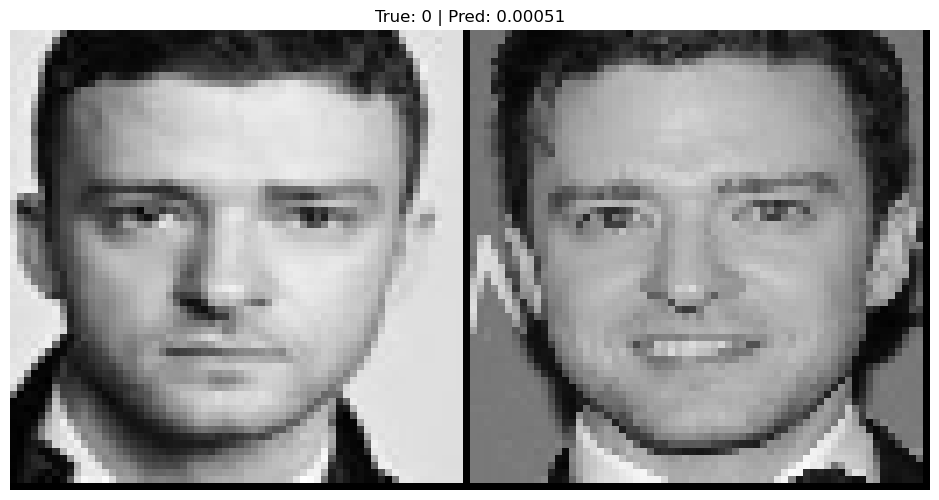

In [71]:
visualize2(pair_test_array, labels_tt, to_show=1, num_col=1, predictions=feature_vector, test=True)